In [181]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as tri
import torch

In [182]:
# Load the Excel file
q_sheet = pd.read_excel("Excel med PLAXIS.xlsx", sheet_name="q")  
head_sheet= pd.read_excel("Excel med PLAXIS.xlsx", sheet_name="Head")  

In [183]:
# Remove any leading/trailing spaces in column names
head_sheet.columns = head_sheet.columns.str.strip()

In [184]:
x = head_sheet["X [m]"].values
y = head_sheet["Y [m]"].values
head = head_sheet["Head [m]"].values

In [185]:
print(x.max(), x.min(), y.max(), y.min(), head.max(), head.min())

59.9794726725665 0.0204720845016275 -0.0131397078025069 -11.9868947373003 19.9999902190223 9.78176043437903e-06


In [186]:
# Define grid for interpolation
head.size

92208

In [187]:
print("Head min:", head.min(), "Head max:", head.max())

Head min: 9.78176043437903e-06 Head max: 19.9999902190223


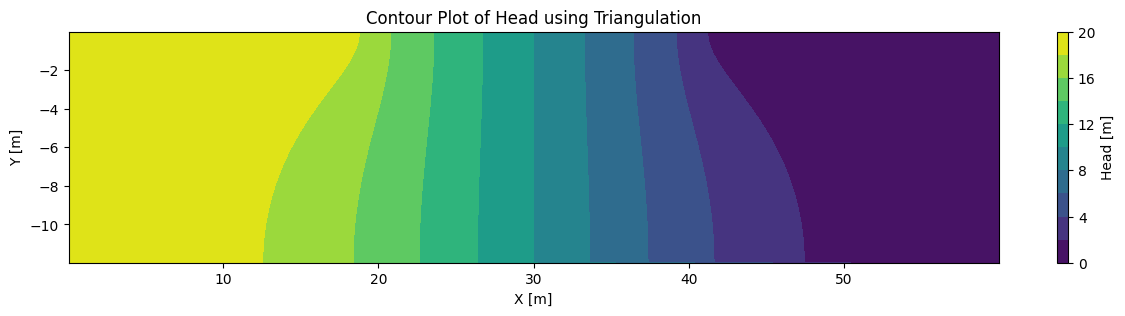

In [188]:
# Create a triangulation object
triang = tri.Triangulation(x, y)

print(triang)

# Plot contour
plt.figure(figsize=(15, 3))
plt.tricontourf(triang, head, levels=10, cmap="viridis")
plt.colorbar(label="Head [m]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Contour Plot of Head using Triangulation")
plt.show()


In [233]:


def compare_nn_to_fem_with_contour(model, fem_x, fem_y, fem_head):
    # Convert FEM points to a torch tensor for NN evaluation
    fem_coords_transformed = torch.tensor(np.column_stack((fem_x/60, (fem_y+12)/60 )), dtype=torch.float32)

    # Get NN predictions at FEM points
    with torch.no_grad():
        nn_predictions = 20 * model(fem_coords_transformed).squeeze().numpy()  # Evaluate the model and convert to numpy

    # Calculate the difference
    absolute_difference = np.abs(nn_predictions - fem_head)
    difference = nn_predictions - fem_head

    # Compute error metrics
    mean_absolute_error = np.mean(absolute_difference)
    max_absolute_error = np.max(absolute_difference)
    rmse = np.sqrt(np.mean((nn_predictions - fem_head) ** 2)) # Root Mean Squared Error

    # Store results in a dictionary
    error_dict = {
        "Mean Absolute Error": mean_absolute_error,
        "Max Absolute Error": max_absolute_error,
        "Root Mean Squared Error (RMSE)": rmse
    }

    # Print errors for reference
    for key, value in error_dict.items():
        print(f"{key}: {value:.6f}")

    # Create triangulation
    triangulation = tri.Triangulation(fem_x, fem_y)

    # Plot absolute and relative error as contour plots
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))

    # Plot FEM head as contour for reference
    rel_contour = ax[0].tricontourf(triangulation, fem_head, levels=20, cmap="viridis")
    fig.colorbar(rel_contour, ax=ax[0])
    ax[0].set_title("Contour Plot of FEM")
    ax[0].set_xlabel("X [m]")
    ax[0].set_ylabel("Y [m]")
    ax[0].grid(True)

    # Plot neural network predictions as contour
    rel_contour = ax[1].tricontourf(triangulation, nn_predictions, levels=20, cmap="viridis")
    fig.colorbar(rel_contour, ax=ax[1])
    ax[1].set_title("Contour Plot of Neural Network Predictions")
    ax[1].set_xlabel("X [m]")
    ax[1].set_ylabel("Y [m]")
    ax[1].grid(True)

    # Plot absolute error contour
    abs_contour = ax[2].tricontourf(triangulation, difference, levels=40, cmap="coolwarm")
    fig.colorbar(abs_contour, ax=ax[2])
    ax[2].set_title("Contour Plot of Difference (NN - FEM)")
    ax[2].set_xlabel("X [m]")
    ax[2].set_ylabel("Y [m]")
    ax[2].grid(True)

    plt.tight_layout()
    plt.show()

    return difference


In [229]:
import torch
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(".."))

# Now import the model class
from model_definition import pinn

# Create a new instance of the model
model = pinn(hidden_size=40, hidden_layers=10)  # Ensure the architecture matches the saved model

# Load the saved state dictionary into this new model instance
model.load_state_dict(torch.load("../trained_pinn_model.pth"))

# Set the model to evaluation mode
model.eval()  # This disables dropout, batch norm, etc., useful if you’re evaluating the model


C:\Users\jolu2\AppData\Local\Temp\ipykernel_22988\2892190954.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../trained_pinn_model.pth

pinn(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): Tanh()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): Tanh()
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=40, bias=True)
    (9): Tanh()
    (10): Linear(in_features=40, out_features=40, bias=True)
    (11): Tanh()
    (12): Linear(in_features=40, out_features=40, bias=True)
    (13): Tanh()
    (14): Linear(in_features=40, out_features=40, bias=True)
    (15): Tanh()
    (16): Linear(in_features=40, out_features=40, bias=True)
    (17): Tanh()
    (18): Linear(in_features=40, out_features=40, bias=True)
    (19): Tanh()
    (20): Linear(in_features=40, out_features=1, bias=True)
  )
)

Mean Absolute Error: 0.079956
Max Absolute Error: 0.860470
Root Mean Squared Error (RMSE): 0.117042


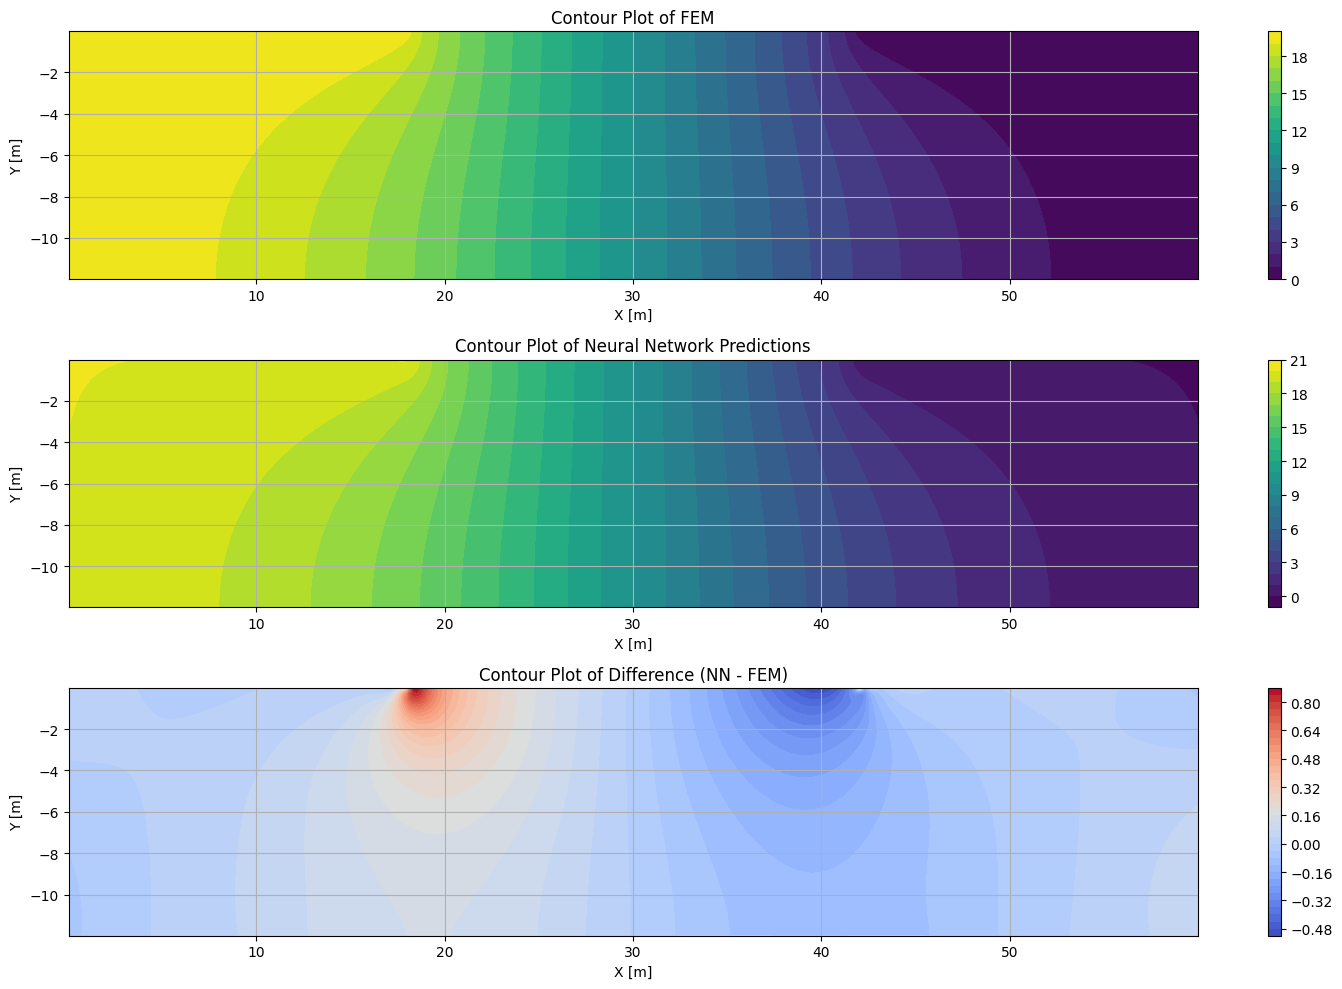

In [234]:
difference=compare_nn_to_fem_with_contour(model,x,y,head)

In [236]:
# Find the index of the maximum head value
max_index = np.argmax(difference)

# Get the coordinates of the maximum head value
max_x = x[max_index]
max_y = y[max_index]
difference_amx = difference[max_index]

print(f"Max head value: {difference_amx} at coordinates (X, Y): ({max_x}, {max_y})")

Max head value: 0.86047036232004 at coordinates (X, Y): (18.4277338083173, -0.0174252678753124)


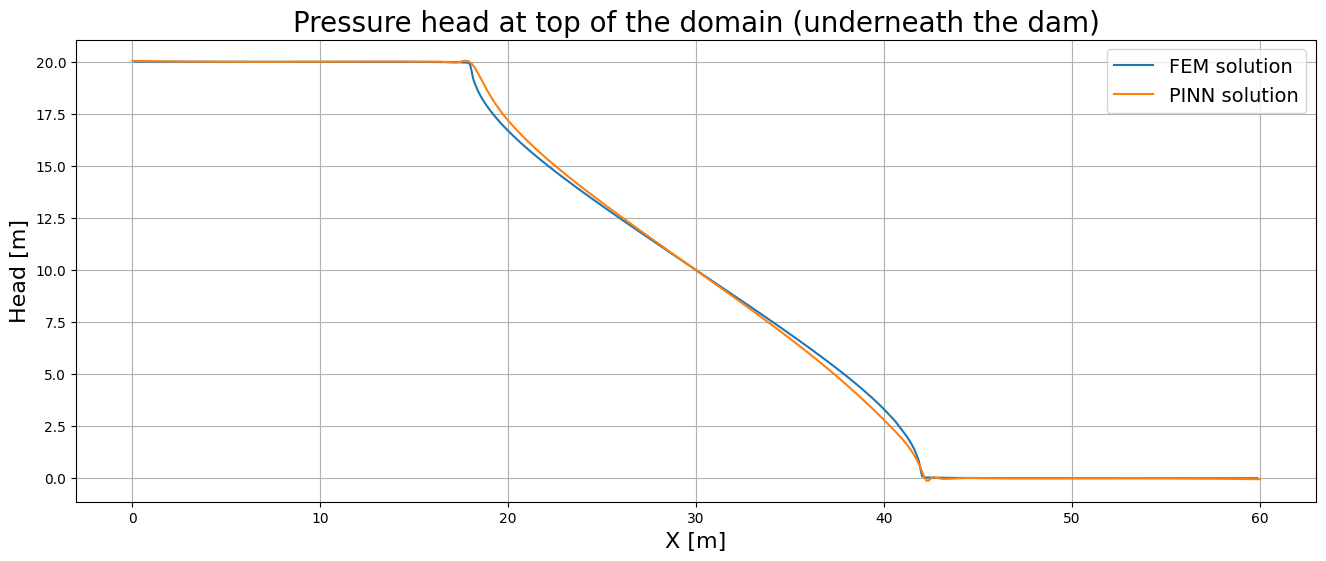

In [232]:
# Assuming x, y, and head are your data
triang = tri.Triangulation(x, y)

# Define a function to extract and interpolate values along y = 0.2
def extract_line(triang, head, y_value=0.2):
    # Find all points in the triangulation close to y = 0.2
    mask = np.isclose(triang.y, y_value, atol=0.225)
    
    # Extract x values and corresponding head values
    x_along_y = triang.x[mask]
    head_along_y = head[mask]
    
    # Sort by x for consistent plotting
    sorted_indices = np.argsort(x_along_y)
    return x_along_y[sorted_indices], head_along_y[sorted_indices]

# Extract the line at y = 0.2
x_line, head_line = extract_line(triang, head, y_value=0.2)

# Define the x values (0 to 1) and keep y fixed at 0.2
x_plot = np.linspace(0, 1, len(x_line))
y_plot = np.full_like(x_plot, 0.2)     # Keep y constant at 0.2
# Create a tensor of x_plot and y_plot
coords_plot = torch.tensor(np.c_[x_plot, y_plot], dtype=torch.float32)

# Evaluate the model
solution = 20*model(coords_plot).detach().numpy()

# Plot the line
plt.figure(figsize=(16, 6))
plt.plot(x_line, head_line, label="FEM solution")
plt.plot(x_plot*60, solution, label="PINN solution")
plt.title("Pressure head at top of the domain (underneath the dam)", size=20)
plt.xlabel("X [m]",size=16)
plt.ylabel("Head [m]",size=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()